#PROCESSING

Nama : Mochammad Hazmi Cokro Mandiri \
NIM : 201710370311240

Deskripsi Dataset : 

Dataset berisi sekumpulan gambar retina yang diambil dengan menggunakan fotografi fundus dalam berbagai kondisi pencitraan.
Terdapat 5 kelas dengan skala 0 - 4 antara lain :

*   0 - No DR
*   1 - Mild
*   2 - Moderate
*   3 - Severe
*   4 - Proliferative DR

Total Gambar = 3662 file

# Library

In [ ]:
# Google Drive
from google.colab import files
from google.colab import drive

# Visualisasi Data
import os
import cv2
import shutil
import random
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Preprocessing data
import pickle
from PIL import Image
import multiprocessing
from keras.utils import np_utils
from keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder
from multiprocessing.pool import ThreadPool
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Hyperparameter Tuning
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

# Melatih / Training data (Model)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePool2D
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, RMSprop, Adamax, SGD
import efficientnet.tfkeras as efn
from keras.models import load_model
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Evaluasi Model
import itertools
from sklearn import metrics
from sklearn.metrics import f1_score, recall_score, accuracy_score, precision_score
from sklearn.metrics import confusion_matrix, classification_report

import warnings 
warnings.filterwarnings('ignore')

2  CPU cores


#[1] Download Dataset 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/201710370311240 - Hazmi Cokro'

/content/drive/MyDrive/201710370311240 - Hazmi Cokro


#[2] Load Data

In [ ]:
file = open('data_train', 'rb')
data_train = pickle.load(file)
file.close()

file = open('data_test', 'rb')
data_test = pickle.load(file)
file.close()

In [ ]:
print(data_train.shape,data_test.shape)

(3112, 4) (550, 4)


#[1] Training Data | GB X=10 | V.Harikrishnan Preprocessing | Warm | Size 224x224 | Hparams

In [ ]:
def img_generator(train,test):
    train_datagen = ImageDataGenerator(rescale=1./255,
                                rotation_range = 90,
                                zoom_range=0.2,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                horizontal_flip=True,
                                vertical_flip=True)
    
    train_generator = train_datagen.flow_from_dataframe(dataframe=data_train,
                                                      directory="./[1.1] GB X=10 Training 224x224",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=12,
                                                      class_mode="categorical",
                                                      target_size=(224, 224),
                                                      shuffle=False,
                                                      subset='training')
    
    test_datagen = ImageDataGenerator(rescale=1./255)

    test_generator = test_datagen.flow_from_dataframe(dataframe=data_test,
                                                      directory = "./[1.1] GB X=10 Testing 224x224",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      target_size=(224, 224),
                                                      batch_size=12,
                                                      shuffle=False,
                                                      class_mode="categorical")
    
    return train_generator,test_generator

In [ ]:
train_generator,test_generator = img_generator(data_train,data_test)

Found 3112 validated image filenames belonging to 5 classes.
Found 550 validated image filenames belonging to 5 classes.


In [ ]:
!pip install -q efficientnet

     |████████████████████████████████| 51kB 4.9MB/s 


In [ ]:
import efficientnet.tfkeras as efn

In [ ]:
from tensorflow.keras.applications import EfficientNetB7
from keras import optimizers

model = tf.keras.Sequential([
         efn.EfficientNetB7(
            input_shape=(224,224, 3),
            weights='noisy-student',
            include_top=False
        ),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(2048, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    
Adamax = optimizers.Adamax(lr=1e-3)
model.compile(optimizer=Adamax, loss="categorical_crossentropy",  metrics=['accuracy'])

258072576/258068648 [==============================] - 7s 0us/step


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
def scheduler(epoch, lr):
    if (epoch < 10):
        return lr
    else:
        return lr * tf.math.exp(-0.03)

LRS = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)

RLROP = ReduceLROnPlateau(monitor='val_loss', 
                              mode='auto',
                              factor=0.5,
                              patience=2, 
                              min_lr=0.00001,
                              cooldown=2,
                              verbose=1)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 7, 7, 2560)        64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              5244928   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5

In [ ]:
import time
start = time.time()

history = model.fit_generator(generator=train_generator,
                                          validation_data=test_generator,
                                          epochs=50,
                                          callbacks=[LRS,RLROP],
                                          verbose=1)

stop = time.time()

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
260/260 [==============================] - 2078s 8s/step - loss: 1.0888 - accuracy: 0.6382 - val_loss: 0.8276 - val_accuracy: 0.6891
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
260/260 [==============================] - 387s 1s/step - loss: 0.8058 - accuracy: 0.7111 - val_loss: 0.6699 - val_accuracy: 0.7236
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
260/260 [==============================] - 387s 1s/step - loss: 0.7415 - accuracy: 0.7233 - val_loss: 0.6035 - val_accuracy: 0.7545
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
260/260 [==============================] - 387s 1s/step - loss: 0.6943 - accuracy: 0.7397 - val_loss: 0.5640 - val_accuracy: 0.7764
Epoch 5/50

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001000000047

In [ ]:
print("--- %s seconds ---" % (stop - start))

--- 20982.180352926254 seconds ---


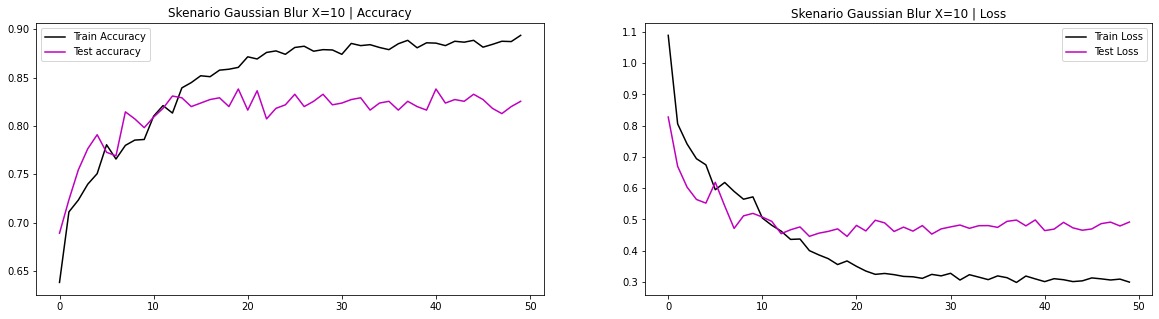

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Skenario Gaussian Blur X=10 | Accuracy')
ax1.legend(['Train Accuracy','Test accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Skenario Gaussian Blur X=10 | Loss')
ax2.legend(['Train Loss','Test Loss'])

plt.savefig("Skenario V Harikrishnan.svg")
plt.show()

###Evaluasi Model

In [ ]:
result_train = model.evaluate_generator(train_generator, 3112  // 12+1)
print('\n', 'Hasil Akurasi Train = {:.4f}'.format(result_train[1]),
      " Hasil Loss Train = {:.4f}".format(result_train[0]))

result_test = model.evaluate_generator(test_generator, 550  // 12+1)
print('\n', 'Hasil Akurasi Test =  {:.4f}'.format(result_test[1]),
      " Hasil Loss Test = {:.4f}".format(result_test[0]))


 Hasil Akurasi Train = 0.8972  Hasil Loss Train = 0.2776

 Hasil Akurasi Test =  0.8236  Hasil Loss Test = 0.4976


In [ ]:
test_generator.reset()
test_preds = model.predict_generator(test_generator, steps=550  // 12+1,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]

print('Confusion Matrix : \n')
print(confusion_matrix(list(data_test['diagnosis'].astype(int)), test_labels))

46/46 [==============================] - 18s 311ms/step


In [ ]:
print('Classification Report : \n')
target_names = ['0', '1', '2', '3', '4']
print(classification_report(list(data_test['diagnosis'].astype(int)), test_labels, target_names=target_names))

print('Confusion Matrix : \n')
print(confusion_matrix(list(data_test['diagnosis'].astype(int)), test_labels))

Classification Report : 

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       276
           1       0.64      0.73      0.69        64
           2       0.73      0.74      0.74       133
           3       0.38      0.36      0.37        25
           4       0.82      0.60      0.69        52

    accuracy                           0.83       550
   macro avg       0.71      0.68      0.69       550
weighted avg       0.84      0.83      0.83       550

Confusion Matrix : 

[[273   3   0   0   0]
 [  3  47  14   0   0]
 [  3  20  99   9   2]
 [  0   1  10   9   5]
 [  0   2  13   6  31]]


In [ ]:
from sklearn.metrics import  precision_recall_curve, auc, roc_curve
from sklearn.metrics import  accuracy_score, precision_score, recall_score, f1_score

y_pred = data_test['diagnosis'].astype(int)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_pred, test_labels)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_pred, test_labels, average='macro')
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_pred, test_labels, average='macro')
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_pred, test_labels, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.834545
Precision: 0.708212
Recall: 0.684804
F1 score: 0.692442


In [ ]:
# precision tp / (tp + fp)
precision = precision_score(y_pred, test_labels, average='weighted')
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_pred, test_labels, average='weighted')
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_pred, test_labels, average='weighted')
print('F1 score: %f' % f1)

Precision: 0.836149
Recall: 0.834545
F1 score: 0.833343


In [ ]:
# precision tp / (tp + fp)
precision = precision_score(y_pred, test_labels, average='micro')
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_pred, test_labels, average='micro')
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_pred, test_labels, average='micro')
print('F1 score: %f' % f1)

Precision: 0.834545
Recall: 0.834545
F1 score: 0.834545


In [ ]:
def plot_conf_matrix(true,pred,classes):
    cf = confusion_matrix(true, pred)
    df_cm = pd.DataFrame(cf, range(len(classes)), range(len(classes)))
    plt.figure(figsize=(8,5.5))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},xticklabels = classes ,yticklabels = classes,fmt='g',cmap="YlGnBu")
    plt.show()

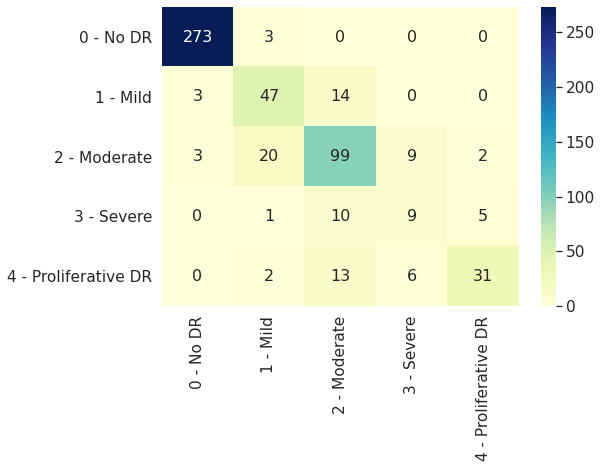

In [ ]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
plot_conf_matrix(list(data_test['diagnosis'].astype(int)),test_labels,labels)

In [ ]:
from keras.models import model_from_json

# serialize model to json
json_model = model.to_json()
#save the model architecture to JSON file
with open('GB X=10 | 15 June.json', 'w') as json_file:
    json_file.write(json_model)
#saving the weights of the model
model.save_weights('GB X=10 | 15 June | Weights.h5')

#[2] Training Data | GB+Crop X=30 | Graham Preprocessing | Warm | Size 224x224 | Hparams

In [ ]:
def img_generator(train,test):
    train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range = 90,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=True)

    train_generator = train_datagen.flow_from_dataframe(dataframe=data_train,
                                                      directory="./[2.1] GB+Crop X=30 Training 224x224",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=12,
                                                      class_mode="categorical",
                                                      target_size=(224, 224),
                                                      shuffle=False,
                                                      subset='training')
    
    test_datagen = ImageDataGenerator(rescale=1./255)

    test_generator = test_datagen.flow_from_dataframe(dataframe=data_test,
                                                      directory = "./[2.1] GB+Crop X=30 Training 224x224",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      target_size=(224, 224),
                                                      batch_size=12,
                                                      shuffle=False,
                                                      class_mode="categorical")
    
    return train_generator,test_generator

In [ ]:
train_generator,test_generator = img_generator(data_train,data_test)

Found 3112 validated image filenames belonging to 5 classes.
Found 550 validated image filenames belonging to 5 classes.


In [ ]:
!pip install -q efficientnet

     |████████████████████████████████| 51kB 3.9MB/s 


In [ ]:
import efficientnet.tfkeras as efn

In [ ]:
from tensorflow.keras.applications import EfficientNetB7
from keras import optimizers

model = tf.keras.Sequential([
         efn.EfficientNetB7(
            input_shape=(224,224, 3),
            weights='noisy-student',
            include_top=False
        ),
        tf.keras.layers.GlobalAveragePooling2D(),        
        tf.keras.layers.Dense(2048, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    
Adamax = optimizers.Adamax(lr=1e-3)
model.compile(optimizer=Adamax, loss="categorical_crossentropy",  metrics=['accuracy'])

258072576/258068648 [==============================] - 3s 0us/step


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
def scheduler(epoch, lr):
    if (epoch < 10):
        return lr
    else:
        return lr * tf.math.exp(-0.1)

LRS = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)

RLROP = ReduceLROnPlateau(monitor='val_loss', mode='auto',factor=0.5, patience=2, 
                          min_lr=0.00001, cooldown=2, verbose=1)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 7, 7, 2560)        64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              5244928   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5

In [ ]:
import time
start = time.time()

history = model.fit_generator(generator=train_generator,
                                          validation_data=test_generator,
                                          epochs=50,
                                          callbacks=[LRS,RLROP],
                                          verbose=1)

stop = time.time()

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
260/260 [==============================] - 1691s 6s/step - loss: 1.2024 - accuracy: 0.5675 - val_loss: 1.0208 - val_accuracy: 0.6236
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
260/260 [==============================] - 243s 934ms/step - loss: 0.9946 - accuracy: 0.6565 - val_loss: 0.8006 - val_accuracy: 0.7200
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
260/260 [==============================] - 243s 933ms/step - loss: 0.9106 - accuracy: 0.6857 - val_loss: 0.7802 - val_accuracy: 0.7309
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
260/260 [==============================] - 243s 934ms/step - loss: 0.8956 - accuracy: 0.6889 - val_loss: 0.7092 - val_accuracy: 0.7455
Epoch 5/50

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001

In [ ]:
print("--- %s seconds ---" % (stop - start))

--- 13631.849700450897 seconds ---


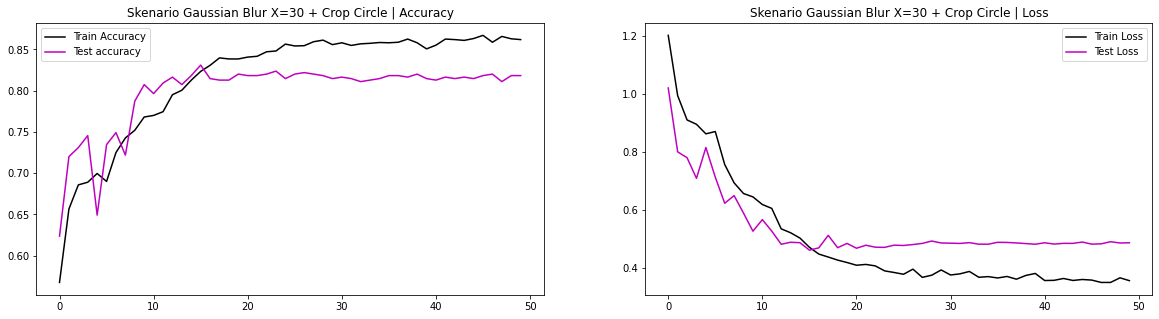

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Skenario Gaussian Blur X=30 + Crop Circle | Accuracy')
ax1.legend(['Train Accuracy','Test accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Skenario Gaussian Blur X=30 + Crop Circle | Loss')
ax2.legend(['Train Loss','Test Loss'])

plt.savefig("Skenario Ben Graham.svg")
plt.show()

###Evaluasi Model

In [ ]:
result_train = model.evaluate_generator(train_generator, 3112  // 12+1)
print('\n', 'Hasil Akurasi Train = {:.4f}'.format(result_train[1])," Hasil Loss Train = {:.4f}".format(result_train[0]))

result_test = model.evaluate_generator(test_generator, 550  // 12+1)
print('\n', 'Hasil Akurasi Test =  {:.4f}'.format(result_test[1])," Hasil Loss Test = {:.4f}".format(result_test[0]))


 Hasil Akurasi Train = 0.8753  Hasil Loss Train = 0.3297

 Hasil Akurasi Test =  0.8182  Hasil Loss Test = 0.4867


In [ ]:
test_generator.reset()
test_preds = model.predict_generator(test_generator, steps=550  // 12+1,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]

46/46 [==============================] - 10s 140ms/step


In [ ]:
print('Classification Report : \n')
target_names = ['0', '1', '2', '3', '4']
print(classification_report(list(data_test['diagnosis'].astype(int)), test_labels, target_names=target_names))

print('Confusion Matrix : \n')
print(confusion_matrix(list(data_test['diagnosis'].astype(int)), test_labels))

Classification Report : 

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       276
           1       0.58      0.77      0.66        64
           2       0.75      0.73      0.74       133
           3       0.33      0.40      0.36        25
           4       0.77      0.44      0.56        52

    accuracy                           0.82       550
   macro avg       0.68      0.66      0.66       550
weighted avg       0.83      0.82      0.82       550

Confusion Matrix : 

[[271   5   0   0   0]
 [  3  49  10   1   1]
 [  2  26  97   6   2]
 [  0   1  10  10   4]
 [  0   3  13  13  23]]


In [ ]:
y_pred = data_test['diagnosis'].astype(int)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_pred, test_labels)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_pred, test_labels, average='weighted')
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_pred, test_labels, average='weighted')
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_pred, test_labels, average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.818182
Precision: 0.828676
Recall: 0.818182
F1 score: 0.817721


In [ ]:
# precision tp / (tp + fp)
precision = precision_score(y_pred, test_labels, average='micro')
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_pred, test_labels, average='micro')
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_pred, test_labels, average='micro')
print('F1 score: %f' % f1)

Precision: 0.818182
Recall: 0.818182
F1 score: 0.818182


In [ ]:
def plot_conf_matrix(true,pred,classes):
    cf = confusion_matrix(true, pred)
    df_cm = pd.DataFrame(cf, range(len(classes)), range(len(classes)))
    plt.figure(figsize=(8,5.5))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},xticklabels = classes ,yticklabels = classes,fmt='g',cmap="YlGnBu")
    plt.show()

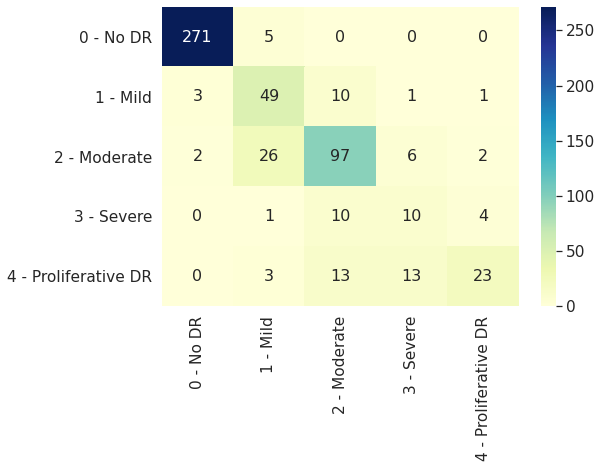

In [ ]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
plot_conf_matrix(list(data_test['diagnosis'].astype(int)),test_labels,labels)

In [ ]:
from keras.models import model_from_json

# serialize model to json
json_model = model.to_json()
#save the model architecture to JSON file
with open('GB X=30 | 20 June.json', 'w') as json_file:
    json_file.write(json_model)
#saving the weights of the model
model.save_weights('GB X=30 | 20 June | Weights.h5')

#[3] Training Data | Usuyama Preprocessing | Warm | Size 224x224 | Hparams

In [ ]:
def img_generator(train,test):
    train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range = 90,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=True)

    train_generator = train_datagen.flow_from_dataframe(dataframe=data_train,
                                                      directory="./[3.1] Usuyama Training 224x224",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=12,
                                                      class_mode="categorical",
                                                      target_size=(224, 224),
                                                      shuffle=False,
                                                      subset='training')
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    test_generator = test_datagen.flow_from_dataframe(dataframe=data_test,
                                                      directory = "./[3.1] Usuyama Testing 224x224",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      target_size=(224, 224),
                                                      batch_size=12,
                                                      shuffle=False,
                                                      class_mode="categorical")
    
    return train_generator,test_generator

In [ ]:
train_generator,test_generator = img_generator(data_train,data_test)

Found 3112 validated image filenames belonging to 5 classes.
Found 550 validated image filenames belonging to 5 classes.


In [ ]:
!pip install -q efficientnet

     |████████████████████████████████| 51kB 4.2MB/s 


In [ ]:
import efficientnet.tfkeras as efn

In [ ]:
from tensorflow.keras.applications import EfficientNetB7
from keras import optimizers

model = tf.keras.Sequential([
         efn.EfficientNetB7(
            input_shape=(224,224, 3),
            weights='noisy-student',
            include_top=False
        ),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(2048, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

Adamax = optimizers.Adamax(lr=1e-3)
model.compile(optimizer=Adamax, loss="categorical_crossentropy",  metrics=['accuracy'])

258072576/258068648 [==============================] - 3s 0us/step


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
def scheduler(epoch, lr):
    if (epoch < 10):
        return lr
    else:
        return lr * tf.math.exp(-0.1)

LRS = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)

RLROP = ReduceLROnPlateau(monitor='val_loss', mode='auto',factor=0.5, patience=2, 
                          min_lr=0.00001, cooldown=2, verbose=1)

In [ ]:
import time
start = time.time()

history = model.fit_generator(train_generator,
                              validation_data=test_generator,
                              epochs=50,
                              callbacks=[LRS,RLROP],
                              verbose=1)
stop = time.time()

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
260/260 [==============================] - 1626s 6s/step - loss: 1.1370 - accuracy: 0.5803 - val_loss: 1.2375 - val_accuracy: 0.6145
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
260/260 [==============================] - 246s 948ms/step - loss: 0.9166 - accuracy: 0.6819 - val_loss: 0.7584 - val_accuracy: 0.7055
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
260/260 [==============================] - 246s 944ms/step - loss: 0.8618 - accuracy: 0.6941 - val_loss: 0.7777 - val_accuracy: 0.7164
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
260/260 [==============================] - 246s 944ms/step - loss: 0.7871 - accuracy: 0.7153 - val_loss: 0.7200 - val_accuracy: 0.7727
Epoch 5/50

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001

In [ ]:
print("--- %s seconds ---" % (stop - start))

--- 13684.582876443863 seconds ---


###Evaluasi Model

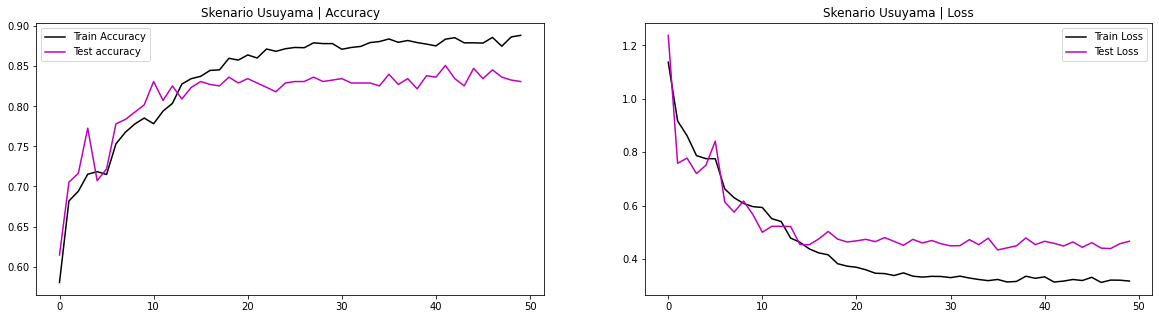

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Skenario Usuyama | Accuracy')
ax1.legend(['Train Accuracy','Test accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Skenario Usuyama | Loss')
ax2.legend(['Train Loss','Test Loss'])

plt.savefig("Skenario Usuyama.svg")
plt.show()

In [ ]:
result_train = model.evaluate_generator(train_generator, 3112  // 12+1)
print('\n', 'Hasil Akurasi Train = {:.4f}'.format(result_train[1])," Hasil Loss Train = {:.4f}".format(result_train[0]))

result_test = model.evaluate_generator(test_generator, 550  // 12+1)
print('\n', 'Hasil Akurasi Test =  {:.4f}'.format(result_test[1])," Hasil Loss Test = {:.4f}".format(result_test[0]))


 Hasil Akurasi Train = 0.8911  Hasil Loss Train = 0.3050

 Hasil Akurasi Test =  0.8436  Hasil Loss Test = 0.4332


In [ ]:
test_generator.reset()
test_preds = model.predict_generator(test_generator, steps=550  // 12+1,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]

46/46 [==============================] - 11s 165ms/step


In [ ]:
print('Classification Report : \n')
target_names = ['0', '1', '2', '3', '4']
print(classification_report(list(data_test['diagnosis'].astype(int)),
                            test_labels, target_names=target_names))

print('Confusion Matrix : \n')
print(confusion_matrix(list(data_test['diagnosis'].astype(int)), test_labels))

Classification Report : 

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       276
           1       0.70      0.69      0.69        64
           2       0.67      0.83      0.74       133
           3       0.30      0.12      0.17        25
           4       0.86      0.60      0.70        52

    accuracy                           0.84       550
   macro avg       0.70      0.64      0.66       550
weighted avg       0.83      0.84      0.83       550

Confusion Matrix : 

[[271   3   2   0   0]
 [  3  44  17   0   0]
 [  2  15 111   4   1]
 [  0   0  18   3   4]
 [  0   1  17   3  31]]


In [ ]:
y_pred = data_test['diagnosis'].astype(int)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_pred, test_labels)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_pred, test_labels, average='weighted')
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_pred, test_labels, average='weighted')
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_pred, test_labels, average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.836364
Precision: 0.831725
Recall: 0.836364
F1 score: 0.827907


In [ ]:
# precision tp / (tp + fp)
precision = precision_score(y_pred, test_labels, average='micro')
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_pred, test_labels, average='micro')
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_pred, test_labels, average='micro')
print('F1 score: %f' % f1)

Precision: 0.836364
Recall: 0.836364
F1 score: 0.836364


In [ ]:
def plot_conf_matrix(true,pred,classes):
    cf = confusion_matrix(true, pred)
    df_cm = pd.DataFrame(cf, range(len(classes)), range(len(classes)))
    plt.figure(figsize=(8,5.5))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},xticklabels = classes ,yticklabels = classes,fmt='g',cmap="YlGnBu")
    plt.show()

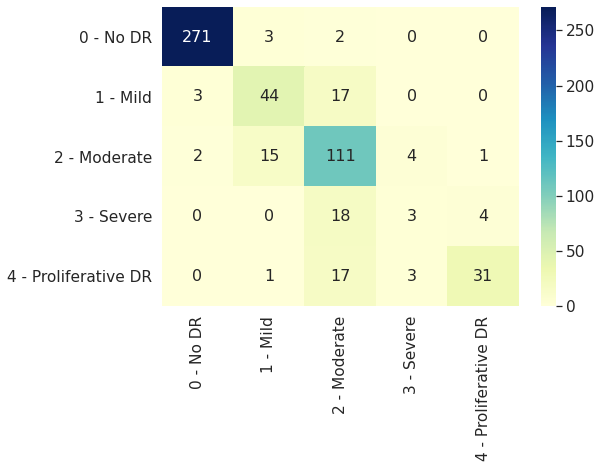

In [ ]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
plot_conf_matrix(list(data_test['diagnosis'].astype(int)),test_labels,labels)

In [ ]:
from keras.models import model_from_json

# serialize model to json
json_model = model.to_json()
#save the model architecture to JSON file
with open('Usuyama | 20 June.json', 'w') as json_file:
    json_file.write(json_model)
#saving the weights of the model
model.save_weights('Usuyama | 20 June | Weights.h5')

#[4] Training Data | Usuyama | Tanpa Augmentasi | Size 224x224 | Hparams

In [ ]:
def img_generator(train,test):
    datagen=ImageDataGenerator(rescale=1./255)

    train_generator=datagen.flow_from_dataframe(dataframe=data_train,
                                                      directory="./[3.1] Usuyama Training 224x224",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=12,
                                                      class_mode="categorical",
                                                      target_size=(224, 224),
                                                      shuffle=False,
                                                      subset='training')
    
    test_generator = datagen.flow_from_dataframe(dataframe=data_test,
                                                      directory = "./[3.1] Usuyama Testing 224x224",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      target_size=(224, 224),
                                                      batch_size=12,
                                                      shuffle=False,
                                                      class_mode="categorical")
    
    return train_generator,test_generator

In [ ]:
train_generator,test_generator = img_generator(data_train,data_test)

Found 3112 validated image filenames belonging to 5 classes.
Found 550 validated image filenames belonging to 5 classes.


In [ ]:
!pip install -q efficientnet

     |████████████████████████████████| 51kB 7.8MB/s 


In [ ]:
import efficientnet.tfkeras as efn

In [ ]:
from tensorflow.keras.applications import EfficientNetB7
from keras import optimizers

model = tf.keras.Sequential([
         efn.EfficientNetB7(
            input_shape=(224,224, 3),
            weights='noisy-student',
            include_top=False
        ),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(2048, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

Adamax = optimizers.Adamax(lr=1e-3)
model.compile(optimizer=Adamax, loss="categorical_crossentropy",  metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
def scheduler(epoch, lr):
    if (epoch < 10):
        return lr
    else:
        return lr * tf.math.exp(-0.1)

LRS = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)

RLROP = ReduceLROnPlateau(monitor='val_loss', mode='auto',factor=0.5, patience=2, 
                          min_lr=0.00001, cooldown=2, verbose=1)

In [ ]:
import time
start = time.time()

history = model.fit_generator(train_generator,
                              validation_data=test_generator,
                              epochs=50,
                              callbacks=[LRS,RLROP],
                              verbose=1)
stop = time.time()

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
260/260 [==============================] - 959s 3s/step - loss: 0.6612 - accuracy: 0.7555 - val_loss: 0.5534 - val_accuracy: 0.7727
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
260/260 [==============================] - 193s 740ms/step - loss: 0.6372 - accuracy: 0.7619 - val_loss: 0.6431 - val_accuracy: 0.7600
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
260/260 [==============================] - 193s 741ms/step - loss: 0.6043 - accuracy: 0.7683 - val_loss: 0.5699 - val_accuracy: 0.7818
Epoch 4/50

Epoch 00004: LearningRateScheduler reducing learning rate to 9.999999747378752e-05.
260/260 [==============================] - 193s 742ms/step - loss: 0.5936 - accuracy: 0.7725 - val_loss: 0.5082 - val_accuracy: 0.8073
Epoch 5/50

Epoch 00005: LearningRateScheduler reducing learning rate to 9.9999

In [ ]:
print("--- %s seconds ---" % (stop - start))

--- 10413.357162952423 seconds ---


###Evaluasi Model

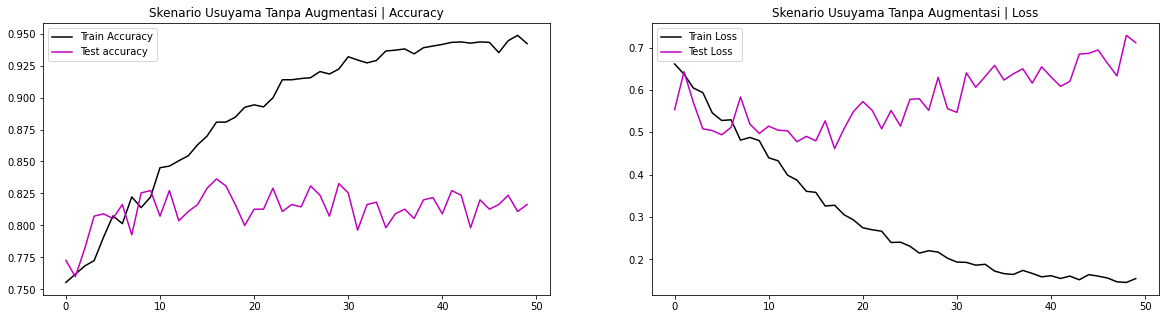

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Skenario Usuyama Tanpa Augmentasi | Accuracy')
ax1.legend(['Train Accuracy','Test accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Skenario Usuyama Tanpa Augmentasi | Loss')
ax2.legend(['Train Loss','Test Loss'])

plt.savefig("Skenario Usuyama tanpa Augmentasi.svg")
plt.show()

In [ ]:
result_train = model.evaluate_generator(train_generator, 3112  // 12+1)
print('\n', 'Hasil Akurasi Train = {:.4f}'.format(result_train[1])," Hasil Loss Train = {:.4f}".format(result_train[0]))

result_test = model.evaluate_generator(test_generator, 550  // 12+1)
print('\n', 'Hasil Akurasi Test =  {:.4f}'.format(result_test[1])," Hasil Loss Test = {:.4f}".format(result_test[0]))


 Hasil Akurasi Train = 0.9438  Hasil Loss Train = 0.1503

 Hasil Akurasi Test =  0.8255  Hasil Loss Test = 0.6568


In [ ]:
test_generator.reset()
test_preds = model.predict_generator(test_generator, steps=550  // 12+1,verbose = 1)
test_labels = [np.argmax(pred) for pred in test_preds]

46/46 [==============================] - 11s 167ms/step


In [ ]:
print('Classification Report : \n')
target_names = ['0', '1', '2', '3', '4']
print(classification_report(list(data_test['diagnosis'].astype(int)), test_labels, target_names=target_names))

print('Confusion Matrix : \n')
print(confusion_matrix(list(data_test['diagnosis'].astype(int)), test_labels))

Classification Report : 

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       276
           1       0.62      0.72      0.67        64
           2       0.70      0.76      0.73       133
           3       0.37      0.28      0.32        25
           4       0.72      0.54      0.62        52

    accuracy                           0.82       550
   macro avg       0.68      0.65      0.66       550
weighted avg       0.82      0.82      0.82       550

Confusion Matrix : 

[[270   4   1   0   1]
 [  3  46  14   1   0]
 [  1  19 101   7   5]
 [  0   1  12   7   5]
 [  0   4  16   4  28]]


In [ ]:
from sklearn.metrics import  precision_recall_curve, auc, roc_curve
from sklearn.metrics import  accuracy_score, precision_score, recall_score, f1_score

y_pred = data_test['diagnosis'].astype(int)

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_pred, test_labels)
print('Accuracy: %f' % accuracy)

# precision tp / (tp + fp)
precision = precision_score(y_pred, test_labels, average='macro')
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_pred, test_labels, average='macro')
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_pred, test_labels, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.821818
Precision: 0.678956
Recall: 0.654974
F1 score: 0.662259


In [ ]:
# precision tp / (tp + fp)
precision = precision_score(y_pred, test_labels, average='weighted')
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_pred, test_labels, average='weighted')
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_pred, test_labels, average='weighted')
print('F1 score: %f' % f1)

Precision: 0.821060
Recall: 0.821818
F1 score: 0.819259


In [ ]:
# precision tp / (tp + fp)
precision = precision_score(y_pred, test_labels, average='micro')
print('Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_pred, test_labels, average='micro')
print('Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_pred, test_labels, average='micro')
print('F1 score: %f' % f1)

Precision: 0.821818
Recall: 0.821818
F1 score: 0.821818


In [ ]:
from keras.models import model_from_json

# serialize model to json
json_model = model.to_json()
#save the model architecture to JSON file
with open('Usuyama Tanpa Augmentasi | 20 June.json', 'w') as json_file:
    json_file.write(json_model)
#saving the weights of the model
model.save_weights('Usuyama Tanpa Augmentasi | 20 June | Weights.h5')